In [ ]:
https://www.youtube.com/watch?v=XyX5HNuv-xE

In [38]:
import os
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## EDA

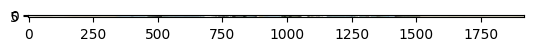

In [94]:
t_image = cv2.imread('rs19_val/jpgs/rs19_val/rs00062.jpg') 
t_image = t_image[:1056,:,:]
plt.imshow(t_image)

In [86]:
temp_mask = cv2.imread('rs19_val/uint8/rs19_val/rs00062.png') #3 channels but all same. 
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

Labels are:  [ 2  5  8  9 10 12 13 15 17]  and the counts are:  [468923  49765 922505  10135 200993 101208  27723 224439  67909]


In [6]:
type(temp_mask)

numpy.ndarray

In [7]:
#width and length of the images
w = temp_mask.shape[0]
l = temp_mask.shape[1]

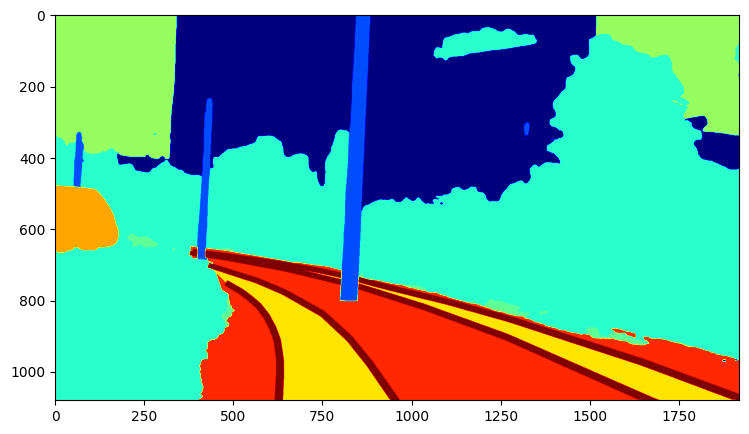

In [8]:
plt.figure(figsize = (10,5))
#before processing
plt.imshow(temp_mask[:,:,0], cmap='jet')

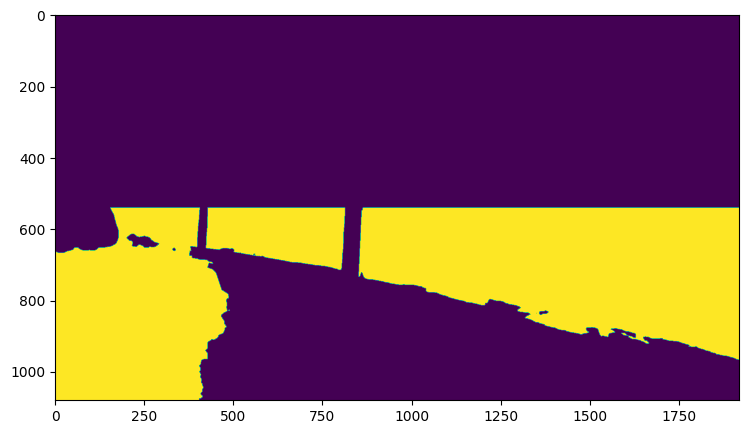

In [9]:
#temp_mask = cv2.imread('rs19_val/uint8/rs19_val/rs00062.png')
plt.figure(figsize = (10,5))
label_of_interest = 8 #veg
#after processing
temp_mask[:int(w/2),:,0]=0
temp_mask[:,:,0][temp_mask[:,:,0]!=label_of_interest]=0
plt.imshow(temp_mask[:,:,0])

In [10]:
len(np.unique(temp_mask[:,:,0]))

2

## Preprosessing

image:  (20, 1056, 1920, 3)
mask:  (20, 1056, 1920)
image:  (20, 1056, 1920, 3)
mask:  (20, 1056, 1920, 1)
unique labels in mask [0 1]


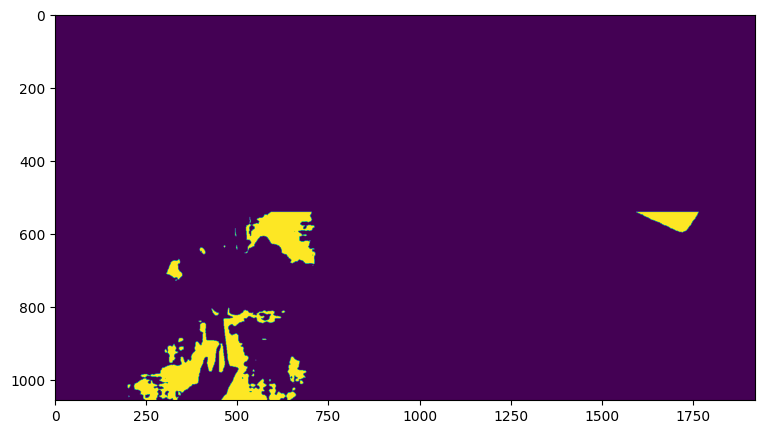

In [97]:
#these codes are used to loop through the directory
path_images = 'rs19_val/jpgs/rs19_val/'
path_mask = 'rs19_val/uint8/rs19_val/'
breaker = 0

image_dataset = []
mask_dataset = []

label_of_interest = 8 #veg
plt.figure(figsize = (10,5))

for filename in os.listdir(path_images):
    breaker +=1
    if filename.endswith('.jpg'):  
        image = cv2.imread(path_images+filename) 
        image = image[:1056,:,:] #divisible by 32 because of UNET requirements
        mask = cv2.imread(path_mask+filename[:7]+'.png')
        mask = mask[:1056,:,:]
        for layer in range(len(mask[0,0,:])):
            mask[:int(w/2),:,layer]=0
            mask[:,:,layer][mask[:,:,layer]!=label_of_interest]=0
            mask[:,:,layer][mask[:,:,layer]==label_of_interest]=1
                #this is because one hot encoder can only deal with 0 and 1 if there is 2 labels
        # image = np.array(image)
        # mask = np.array(mask)
        image_dataset.append(image)
        mask_dataset.append(mask)
    if breaker==20:
         break

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
mask_dataset = mask_dataset[:,:,:,0]
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)
plt.imshow(mask[:,:,0])

mask_dataset = np.expand_dims(mask_dataset, axis=3)
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

print('unique labels in mask', np.unique(mask_dataset))

In [101]:
# split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


# Model

In [102]:
# Preprocessing
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)


In [103]:
X_train.shape

(16, 1056, 1920, 3)

In [104]:
# define the model
BACKBONE = 'resnet34'
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

print(model.summary())

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_442 (ZeroPaddin  (None, None, None,   0          ['bn_data[0][0]']                
 g2D)                           3)                                                         

In [105]:
history = model.fit(    X_train,
                        y_train,
                        batch_size=8,
                        epochs=10,
                        verbose=1,
                        validation_data=(X_test,y_test))

Epoch 1/10
1/2 [==============>...............] - ETA: 2:51 - loss: 0.9190 - mse: 0.3351